# Setting Up the Notebook

Before proceeding with the creation of the dataset needed for the experiment, we need to install and import some libraries. More specifically, we need to install the Python library that allows to read NIFTI images (the format in which the PET scans are stored).

In [ ]:
!pip install nibabel p_tqdm 2>&1 >/dev/null

from p_tqdm import p_uimap
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import glob
import pandas as pd
import sys
import re
import yaml
import cv2

We can then proceed with the mounting of the Google Drive folder, that will be needed later to actually use the data. Here, we've chosen as mountpoint the `/datasets/drive` folder.

In [ ]:
!mkdir /datasets -p
from google.colab import drive
drive.mount('/datasets/drive', force_remount=True)

Mounted at /datasets/drive


We can now set some variables for ensuring the reproducibility of the experiment and the readability of the code. More specifically, we'll set the path to the mounted Google Drive folder that contains the "raw" scans, as well as the random seed and a flag that tells if this is the first run of the notebook or not (so that it won't regenerate unneeded CSV files that may be different for each run).

In [ ]:
import os
import random
from pathlib import Path
DATA_DIR = Path("Your directory here")
RANDOM_SEED = 1234
random.seed(RANDOM_SEED)
FIRST_RUN = True

# Importing the Data

## Importing the CSV data

The OASIS 3 dataset provides different CSV files that contain various information about the visits of each patient. Here, we're importing them and we're fixing some of the errors that they contain (e.g., the CSVs implicitly contain information regarding the date and the subject, that we'll make explicit).

In [ ]:
subjects = pd.read_csv(DATA_DIR / 'csv/subjects.csv')
clinical_data = pd.read_csv(DATA_DIR / 'csv/clinical-data.csv')
pet_data = pd.read_csv(DATA_DIR / 'csv/pet.csv')
pup_data = pd.read_csv(DATA_DIR / 'csv/pup.csv')
mri_data = pd.read_csv(DATA_DIR / 'csv/mri.csv')

# By default, the CSVs do not contain some information explicitly
# (although the columns have been defined). Thus, here we set them
# to usable values.

pup_data['Date'] = (pup_data['PUP_PUPTIMECOURSEDATA ID']
                        .apply(lambda s: int(s.split('_')[3][1:])))
pup_data['Subject'] = (pup_data['PUP_PUPTIMECOURSEDATA ID']
                           .apply(lambda s: s.split('_')[0]))

clinical_data['Date'] = (clinical_data['ADRC_ADRCCLINICALDATA ID']
                             .apply(lambda s: int(s.split('_')[2][1:])))

pet_data['Tracer'] = (pet_data['XNAT_PETSESSIONDATA ID']
                          .map(lambda x: x.split('_')[1]))

Thus, the composition of the dataset is as follows:

In [ ]:
print("Number of subjects:", subjects.shape[0])
print("Number of MRI scans:", mri_data.shape[0])
print("Number of PET scans:", pet_data.shape[0])
print("Number of PUP results:", pup_data.shape[0])

Number of subjects: 1098
Number of MRI scans: 2168
Number of PET scans: 1607
Number of PUP results: 1352


In [ ]:
pup_data['tracer'].value_counts()

PIB     935
AV45    417
Name: tracer, dtype: int64

# Labelling the Data

The OASIS3 dataset does not contain explicit labels for each PET scan. Thus a labelling phase is needed. We start by using the "clinical data" CSV file, that contains at most five differential diagnosis for each visit for each patient. Here, we'll normalize the format by replacing the "dots" as empty cells.

In [ ]:
clinical_data.replace({'.': None, np.nan: None}, inplace=True)

We can now simplify the diagnosis by mapping each diagnosis to either 1 (meaning that the patient suffers from Alzheimer's or other similar diseases) or 0 (meaning that the patient is healthy or suffers from different diseases).

In [ ]:
labels = set()  
for i in range(1, 6):
    labels = labels.union(clinical_data[f'dx{i}'].unique())
simplified = {str(k): re.match('^(AD dem|Vasc.*? dem|Frontotemporal dem|other mental retarAD demion|(Active )?DLBD|Active PSNP|Dementia)', str(k), re.I) is not None for k in labels}
simplified = {k: v or re.match('^uncertain.*?dem', k) is not None for k, v in simplified.items()}
# We classify uncertain cases as sick

Thus, by attaching the newly created diagnosis to the original CSV, we obtain the following distribution:

False    4691
True     1533
Name: dementia, dtype: int64

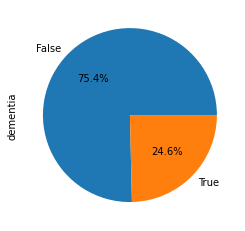

In [ ]:
clinical_data['dementia'] = clinical_data[[f'dx{i}' for i in range(1,6)]].replace(simplified).any(axis=1)
clinical_data['dementia'].value_counts().plot.pie(autopct='%1.1f%%')
clinical_data['dementia'].value_counts()

It is clear that, since dementia is a spectrum rather than a symptom, there may be some "uncertain" cases:

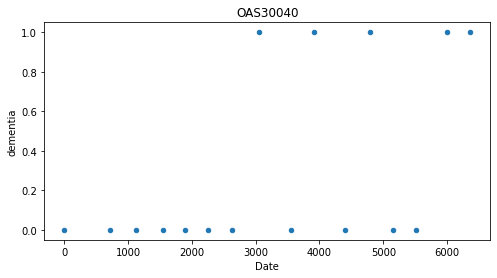

In [ ]:
subj = 'OAS30040'
(clinical_data.groupby('Subject')
    .get_group(subj)
    .replace({True: 1, False: 0})
    .plot.scatter(x='Date', y='dementia', title=subj, figsize=(8,4)))
plt.show()

We thus apply a simple algorithm that tries to find and correct any such cases.

In [ ]:
clinical_data = clinical_data.sort_values(by=['Subject', 'Date']).reset_index(drop=True)
current_subj = None
for index, row in clinical_data.iterrows():
    if current_subj != row['Subject']:
        current_subj = row['Subject']
        prec = (None, None) # i-2, i-1
        succ = (clinical_data.at[index + 1, 'dementia'] if index + 1 in clinical_data.index and clinical_data.at[index + 1, 'Subject'] == current_subj else None, clinical_data.at[index + 2, 'dementia'] if index + 2 in clinical_data.index and clinical_data.at[index + 2, 'Subject'] == current_subj else None)
    
    if row['dementia'] == True:
        new = prec[1] or any(succ)
    else:
        new = any(prec) and any(succ)
    clinical_data.at[index, 'dementia'] = new
    
    prec = (prec[1], new) # i-1, i
    succ = (succ[1], clinical_data.at[index + 3, 'dementia'] if index + 3 in clinical_data.index and clinical_data.at[index + 3, 'Subject'] == current_subj else None)

Applying this algorithm, the previous example becomes as follows (thus all false negatives have been fixed).

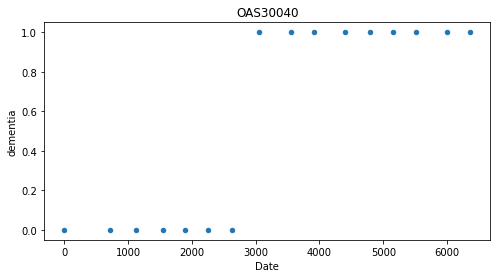

In [ ]:
subj = 'OAS30040'
(clinical_data.groupby('Subject')
    .get_group(subj)
    .replace({True: 1, False: 0})
    .plot.scatter(x='Date', y='dementia',title=subj, figsize=(8,4)))
plt.show()

We can finally attach a label to each PET scan by associating the label of the nearest visit in time.

In [ ]:
labeled_dataset = pup_data.copy()
labeled_dataset.drop(columns=['procType', 'model', 'templateType', 'FSId', 'mocoError', 'regError', 'Centil_fBP_TOT_CORTMEAN', 'Centil_fSUVR_TOT_CORTMEAN', 'Centil_fBP_rsf_TOT_CORTMEAN', 'Centil_fSUVR_rsf_TOT_CORTMEAN'], inplace=True)
labeled_dataset['Label'] = None
for index, row in labeled_dataset.iterrows():
    rows_of_subject = clinical_data.loc[clinical_data['Subject'] == row['Subject']][['Date', 'dementia']]
    rows_of_subject['Date'] = rows_of_subject['Date'].apply(lambda x: abs(x - row['Date']))
    labeled_dataset.at[index,'Label'] = (rows_of_subject.groupby(by='Date', as_index=False) 
                                                        .any()
                                                        .sort_values(by='Date')
                                                        .loc[0]['dementia'])
    
labeled_dataset.to_csv(DATA_DIR / 'csv' / 'labeled_dataset.csv')

## Dealing with Class Imbalance

By plotting the composition of the dataset, it is clear that we're working with an heavily imbalanced dataset.

False    0.900148
True     0.099852
Name: Label, dtype: float64

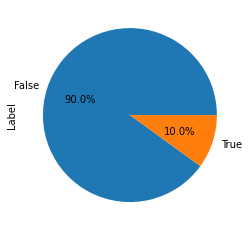

In [ ]:
labeled_dataset['Label'].value_counts().plot.pie(autopct='%1.1f%%')
labeled_dataset['Label'].value_counts(normalize=True)

In [ ]:
labeled_dataset.shape

(1352, 6)

To fix this issue, we apply a combination of random undersampling on negative samples and data augmentation on positive samples.

### Grouping scans by subject

Since many scans are associated to a single subject, in order to avoid future bias at training time, we decide to take only one scan for each subject. More specifically, we take the most recent scan take for a patient.

In [ ]:
new_dataset = labeled_dataset.sort_values(['Subject','Date'], ascending=[True,True])
new_dataset.drop_duplicates(subset=['Subject'], keep='last', inplace=True)
new_dataset['Label'].value_counts()

False    618
True     112
Name: Label, dtype: int64

### Random Undersampling

We randomly select a subset of negative samples, by making sure that we try and keep as most data on the positive patients as possible. To ensure reproducibility, we save the selected negative samples to a CSV.

In [ ]:
if FIRST_RUN:
    positive = new_dataset.loc[labeled_dataset['Label'] == True]
    positive.to_csv(DATA_DIR / 'csv' / 'new-positive.csv')
    negative = new_dataset.loc[labeled_dataset['Label'] == False]
    negative = negative.sample(n = 150, random_state=RANDOM_SEED)
    negative.sort_values(['Subject'], ascending=[True], inplace=True)
    negative.to_csv(DATA_DIR / 'csv' / 'new-negative.csv')

    sampled = pd.concat([positive, negative])
    sampled.to_csv(DATA_DIR / 'csv' /'new_sample.csv')
else:
    sampled = pd.concat([pd.read_csv(DATA_DIR / 'csv/new-positive.csv'), pd.read_csv(DATA_DIR / 'csv/new-negative.csv')])

The modified dataset composition becomes as follows:

False    150
True     112
Name: Label, dtype: int64

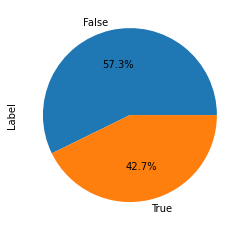

In [ ]:
sampled['Label'].value_counts().plot.pie(autopct='%1.1f%%')
sampled['Label'].value_counts()

We need to trace the corresponding MRI for each of the selected PET

To obtain the same balancement of the PET's dataset, it is necessary to augment positive MRIs, until both of them reach 150 occurencies.

### Data augmentation

To further reduce the unbalancing of the dataset, we augment the positive samples through the means of random rotations and flips.

In [ ]:
from scipy.ndimage.interpolation import rotate

# This rotation fills the empty space in the corners with the mean of colours from the corner-patch
def rotate_img(img, angle, bg_patch=(5, 5)):
    assert len(img.shape) <= 3, "Incorrect image shape"
    rgb = len(img.shape) == 3
    if rgb:
        bg_color = np.mean(img[: bg_patch[0], : bg_patch[1], :], axis=(0, 1))
    else:
        bg_color = np.mean(img[: bg_patch[0], : bg_patch[1]])
    img = rotate(img, angle, reshape=False)
    mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
    img[mask] = bg_color
    return img


def transform(img, fn):
    transformed = img.copy()
    for f in fn.split("|"):
        grp = re.match(r"^rotate:(-?\d+?)$", f)
        if grp:
            angle = int(grp.group(1))
            for i in range(transformed.shape[0]):
                transformed[i, :, :] = rotate_img(transformed[i, :, :], angle)
        elif f == "flipv":
            transformed = transformed[:, ::-1, :]
        elif f == "fliph":
            transformed = transformed[:, :, ::-1]
        else:
            raise ValueError(f"Illegal 'fn' value '{fn}'")
    return transformed

First let's analyze the content of each MRI folder:

In [ ]:
if FIRST_RUN:
  !ls "$DATA_DIR"/mri/all/*/* | sed -n 's/^.*_ses-d...._\(.*\)\.json/\1/p' | sort | uniq -c

Since there are several scans for each MRI, all saved in different subdirectories, we need to extract all of them into the MRI root directory

In [ ]:
if FIRST_RUN:
  !ls "$DATA_DIR"/mri/all/ | xargs -I% sh -c 'mv "$DATA_DIR"/mri/all/%/anat*/* "$DATA_DIR"/mri/all/%/'

Some scan could have been repeated several times: for this reason we take the last version of the T1W for each folder

In [ ]:
if FIRST_RUN:
  !ls "$DATA_DIR"/mri/all | xargs -I% sh -c 'mkdir "$DATA_DIR"/mri/all/%/saved'
  !ls "$DATA_DIR"/mri/all | xargs -I% sh -c 'mkdir "$DATA_DIR"/mri/all/%/discarded'

In [ ]:
import shutil

if FIRST_RUN: 
  mri_folders = os.listdir(DATA_DIR/'mri' / 'all')
  to_save_t1 = ''
  base_t1 = ''
  for p in mri_folders:
    current = os.listdir(DATA_DIR/'mri'/'all'/p)
    print('Listing',p)
    max_t1 = 1
    for f in current:
      print('\tCurrent:',f)
      if "run" in f and "T1w" in f and "echo" not in f:
        if max_t1 < int((f.split("run")[1])[2]):
          max_t1 = int((f.split("run")[1])[2])
          to_save_t1 = f.split('.')[0]
      elif "T1w" in f and "echo" not in f:
        base_t1 = f.split('.')[0]
    if max_t1 > 1:
      print('Copying', to_save_t1)
      nii = to_save_t1 + ".nii.gz"
      json = to_save_t1 + ".json"
      shutil.copy(DATA_DIR/'mri'/'all'/p/nii, DATA_DIR/'mri'/'all'/p/'saved')
      shutil.copy(DATA_DIR/'mri'/'all'/p/json, DATA_DIR/'mri'/'all'/p/'saved')
    else:
      nii = base_t1 + ".nii.gz"
      json = base_t1 + ".json"
      print('Copying', base_t1)
      shutil.copy(DATA_DIR/'mri'/'all'/p/nii, DATA_DIR/'mri'/'all'/p/'saved')
      shutil.copy(DATA_DIR/'mri'/'all'/p/json, DATA_DIR/'mri'/'all'/p/'saved')

We then move every file but the last T1W in a *discared* folder.

In [ ]:
import shutil

mri_folders = os.listdir(DATA_DIR/ 'mri' / 'all')
for p in mri_folders:
  saved = os.listdir(DATA_DIR/'mri'/ 'all' /p/ 'saved')
  current = os.listdir(DATA_DIR/'mri'/ 'all' /p)
  if len(os.listdir(DATA_DIR/'mri'/'all'/p/'discarded')) != 0:
    for f in current:
      if f not in saved and ('saved' not in f and 'discarded' not in f):
        print('Moving',f,'of',p)
        shutil.move(str(DATA_DIR / 'mri'/ 'all' / p / f), str(DATA_DIR / 'mri'/ 'all' / p / 'discarded'))


In [ ]:
! rm -r "$DATA_DIR"/mri/positive/**

Now we divide the scans into two subfolders *positive* and *negative*

In [ ]:
if FIRST_RUN:
  sampled = pd.read_csv(DATA_DIR/'csv'/'new_sample.csv')
  pos = sampled['MRId'].loc[sampled['Label'] == True].values
  neg = sampled['MRId'].loc[sampled['Label'] == False].values

  for p in pos:
    !cp -r "$DATA_DIR"/'mri/all'/"$p" "$DATA_DIR"/mri/positive/
  for n in neg:
    !cp -r "$DATA_DIR"/'mri/all'/"$n" "$DATA_DIR"/mri/negative/

To ensure reproducibility, we save in a CSV a list of the randomly selected images that will be modified, as well as the ordered list of operations that have been applied.

In [ ]:
if FIRST_RUN:
    mri_images = [str(s) for s in DATA_DIR.glob('mri/positive/**/saved/*.nii.gz')]
    mri_paths = random.sample(mri_images, k=43)
    mod_mri_df = pd.DataFrame(columns=['Date', 'Subject', 'MRId', 'Label'], index=np.arange(0,len(mri_paths)))
    sampled = pd.read_csv(DATA_DIR / 'csv' / 'new_sample.csv')

    for i, path in enumerate(mri_paths):
        # Need to store both the .nii img and the one with mean,
        # so we can use the .nii for saving later 
        nii_img = nib.load(path)
        img = nii_img.dataobj
        transformation_functions = random.choices(['rotate', 'flipv', 'fliph'],
                                            weights=[0.5, 0.25, 0.25],
                                            k=random.randint(1,5))
        transformation_functions = [s + f':{random.randrange(-30, 30)}' if s == 'rotate' else s for s in transformation_functions]
        transform_string = '|'.join(transformation_functions)
        mod_mri_df.loc[i] = [str(Path(path).parent.parent).split('_d')[1], str(Path(path).parent.parent).split('/')[-1].split('_')[0], str(Path(path).parent.parent).split('/')[-1], transform_string]
        # Apply the transformation function(s)
        transformed_img = transform(np.array(img),transform_string)
        to_save_img = nib.Nifti1Image(transformed_img, nii_img.affine)
        # Save the new generated image (as: ORIGINALE_modID.4dfp.img)
        img_name = path.split('/')[-1].split('.')[0]
        nib.save(to_save_img, DATA_DIR / 'mri' / 'modified' / (img_name + f'_mod{i}.4dfp.nii'))
    
    mod_mri_df.to_csv(DATA_DIR/'csv'/'modified-mri.csv', index='False')
    
else:
    mod_mri_df = pd.read_csv(DATA_DIR / 'csv' / 'modified-mri.csv')


# Preparing the data

## Resizing the Images

To resize the images to a common size, we'll compute a bounding box of the brain (in order to center it) and we'll select the 20 middle slices of each PET scan. Thus, we start by defining a function to compute the bounding box using the Otsu threshold method.

In [ ]:
def find_brain_bounding_box(image):
    x,y,w,h = (image.shape[0]+1, image.shape[1]+1, -1, -1)
    for slice in image.T:
        blurred = cv2.GaussianBlur(slice.T, (51, 51), 50)
        blurred = blurred.astype(np.float64)
        blurred *= 255.0 / blurred.max()
        blurred[np.where(blurred < 0)] = 0
        blurred = blurred.astype(np.uint8)
        ret, thres = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        blurred_thres = cv2.medianBlur(thres, 51)
        contours, hierarchy = cv2.findContours(blurred_thres, 1, cv2.CHAIN_APPROX_SIMPLE )
        curr_x, curr_y, curr_w, curr_h = cv2.boundingRect(contours[0])
        w = max(w, curr_x + curr_w)
        h = max(h, curr_y + curr_h)
        x = min(x, curr_x)
        y = min(y, curr_y)
    # provide a small padding around the found box:
    x = max(x - 10, 0)
    y = max(y - 10, 0)
    w = min(w + 10, image.shape[0])
    h = min(h + 10, image.shape[1])
    return x, y, w, h

We then define a function to normalize the images

In [ ]:
def normalize(volume):
    """Normalize the volume"""
    volume = np.array(volume)
    min = volume.min()
    max = volume.max()
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

And we define a function to resize the images to $(128, 128, 50)$ voxels.

In [ ]:
def resize_to_input_shape(img):
    shape = (128, 128)
    n_frames = 50
    # Starting index to extract the 50 central frames of the third dimension
    index = int(img.shape[2] / 2) - int(n_frames / 2)
    final_img = img[:,:,index : index + n_frames]
    x, y, w, h = find_brain_bounding_box(final_img)
    square_size = max(w - x, h - y)
    to_square = square_size - w + x, square_size - h + y
    miss_x, miss_y = to_square
    x, y = max(int(x - np.floor(miss_x / 2)), 0), max(int(np.floor(y - miss_y / 2)), 0)
    w, h = int(np.floor(w + miss_x / 2)), int(np.floor(h + miss_y / 2))
    return np.array(
        [
            #cv2.resize(frame, shape)
            cv2.resize(frame[x:w,y:h], shape)
            for frame in final_img.T
        ]
    ).T

Finally, we can define a function that applies all the needed transformations.

In [ ]:
def process_scan(path):
    """Read and resize volume"""
    try:
        # Read scan
        volume = nib.load(path).get_fdata()
        if len(volume.shape) == 4:
          volume = np.mean(volume, axis=3)
        # Normalize
        volume = normalize(volume)
        # Resize width, height and depth
        volume = resize_to_input_shape(volume)
        return volume
    except OSError:
        print("Error in reading", path, "(file could be damaged)", file=sys.stderr)
        return None

We can then load a list of all the PET scans that we'll be loaded

In [ ]:
import pickle
if FIRST_RUN:
  pos_mri = [str(s) for s in DATA_DIR.glob('mri/positive/**/saved/*.nii.gz')]
  neg_mri = [str(s) for s in DATA_DIR.glob('mri/negative/**/saved/*.nii.gz')]
  mod_mri = [str(s) for s in DATA_DIR.glob('mri/modified/*.nii')]
  # Saving the paths of every scans in text file for faster reading

  pos_paths = open(DATA_DIR/'csv'/'pos_paths.txt','wb')
  pickle.dump(pos_mri,pos_paths)
  pos_paths.close()

  neg_paths = open(DATA_DIR/'csv'/'neg_paths.txt','wb')
  pickle.dump(neg_mri,neg_paths)
  neg_paths.close()

  mri_mod_paths = open(DATA_DIR/'csv'/'mri_mod_paths.txt','wb')
  pickle.dump(mod_mri,mri_mod_paths)
  mri_mod_paths.close()
else:
  pos_mri = pickle.load(open(DATA_DIR/'csv'/'pos_paths.txt','rb'))
  neg_mri = pickle.load(open(DATA_DIR/'csv'/'neg_paths.txt','rb'))
  mod_mri = pickle.load(open(DATA_DIR/'csv'/'mri_mod_paths.txt','rb'))

In [ ]:
import pickle
pos_mri = pickle.load(open(DATA_DIR/'csv'/'pos_paths.txt','rb'))
neg_mri = pickle.load(open(DATA_DIR/'csv'/'neg_paths.txt','rb'))
mod_mri = pickle.load(open(DATA_DIR/'csv'/'mri_mod_paths.txt','rb'))

We can print the availability of the scans (note that the dataset is balanced as the modified images are only positive).

In [ ]:
print("Total number of positive MRI:",(len(pos_mri) + len(mod_mri)))
print("Total number of negative MRI:",(len(neg_mri)))

Total number of positive MRI: 148
Total number of negative MRI: 148


Before applying the processing functions to all the images in batch, we can test the resizing function on a single image to check if everything works as desired.

(176, 240, 50)


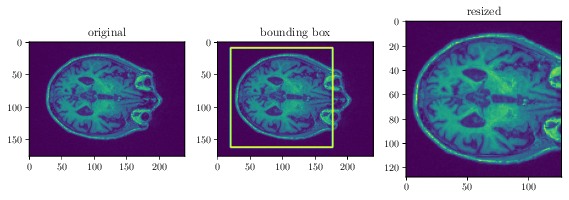

In [ ]:
path = pos_mri[-2]
pos = np.array(nib.load(path).dataobj)
r_pos = process_scan(path)
fig,ax = plt.subplots(1,3, figsize=(8,8))
plt.savefig(DATA_DIR/'original.png', bbox_inches='tight')
ax[0].imshow(pos[:,:,int(pos.shape[2]/2)])
ax[0].set_title('original')
index = int(pos.shape[2] / 2) - int(50 / 2)
sliced = pos[:,:,index : index + 50]
print(sliced.shape)
rect = find_brain_bounding_box(sliced)
plt.savefig(DATA_DIR/'bounding.png', bbox_inches='tight')
ax[1].imshow(cv2.rectangle(normalize(sliced[:,:,int(sliced.shape[2]/2)]), (rect[0],rect[1]), (rect[2],rect[3]), 1, 2).get())
ax[1].set_title('bounding box')
plt.savefig(DATA_DIR/'resized.png', bbox_inches='tight')
ax[2].imshow(r_pos[:,:,25])
ax[2].set_title('resized')
plt.tight_layout()
plt.show()

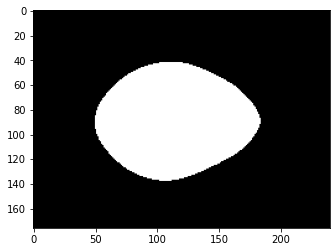

In [ ]:
img = pos[:,:,25]
blurred = cv2.GaussianBlur(img, (51, 51), 50)
blurred = blurred.astype(np.float64)
blurred *= 255.0 / blurred.max()
blurred[np.where(blurred < 0)] = 0
blurred = blurred.astype(np.uint8)
ret, thres = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
blurred_thres = cv2.medianBlur(thres, 51)
plt.imshow(blurred_thres, cmap='gray')

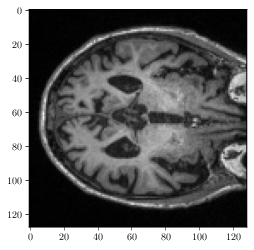

In [ ]:
im = pos[:,:,int(pos.shape[2]/2)]
imS = cv2.resize(im, (128,128))
plt.imshow(imS)
plt.savefig(DATA_DIR/'original.pgf')
blurred_thres = cv2.resize(blurred_thres, (128, 128))
im = blurred_thres
imS = cv2.resize(im, (128,128))
plt.imshow(imS, cmap='gray')
plt.savefig(DATA_DIR/'otsu.pgf')
im = cv2.rectangle(normalize(sliced[:,:,int(sliced.shape[2]/2)]), (rect[0],rect[1]), (rect[2],rect[3]), 1, 2).get()
imS = cv2.resize(im, (128, 128))
plt.imshow(imS)
plt.savefig(DATA_DIR/'bounding.pgf')
im = r_pos[:,:,25]
imS = cv2.resize(im, (128, 128))
plt.imshow(imS)
plt.savefig(DATA_DIR/'resized.pgf')
im = r_pos[:,:,25]
imS = cv2.resize(im, (128, 128))
plt.imshow(imS,cmap='gray')
plt.savefig(DATA_DIR/'final.pgf')

(176, 240, 256)
(128, 128, 50)


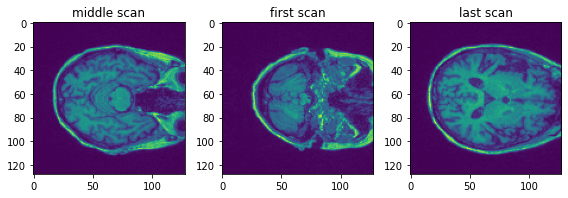

In [ ]:
test_img = np.array(nib.load(pos_mri[-2]).dataobj)
print(test_img.shape)
r_pos = process_scan(pos_mri[0])
print(r_pos.shape)
fig,ax = plt.subplots(1,3, figsize=(8,8))
ax[0].imshow(r_pos[:,:,25])
ax[0].set_title('middle scan')
ax[1].imshow(r_pos[:,:,0])
ax[1].set_title('first scan')
ax[2].imshow(r_pos[:,:,49])
ax[2].set_title('last scan')
plt.tight_layout()
plt.show()

We can now load and process all the images.

In [ ]:
pos = np.array(list(filter(lambda x: x is not None and np.array(x).shape[-1] ==20, p_uimap(process_scan, pos_images + pos_mod_images))))
pos_label = np.ones(len(pos)*20, dtype=np.uint8)
neg = np.array(list(filter(lambda x: x is not None and np.array(x).shape[-1] == 20, p_uimap(process_scan, neg_images + neg_mod_images))))
neg_label = np.zeros(len(neg)*20, dtype=np.uint8)

  0%|          | 0/205 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

We can then transform the 3D images to a sequence of 2D images (to reduce the required computing power in the training phase).

In [ ]:
x = np.concatenate((*np.concatenate((pos, neg), axis=0),), axis = 2).T
print(x.shape)
y = np.concatenate((pos_label, neg_label), axis=0)

(8200, 128, 128)


To check if everything worked as expected, the size of the list of images and the list of labels should be the same.

In [ ]:
print(x.shape, y.shape)

(8200, 128, 128) (8200,)


Furthermore a single image should have a size of $128\times 128$ pixels.

In [ ]:
x[0].shape

(128, 128)

We can plot an example image to check it.

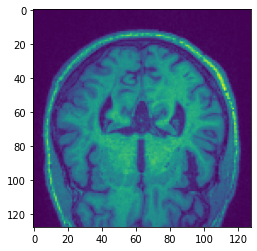

In [ ]:
plt.imshow(x[1])

## Generating the CV Folds

To reduce the required time in later phases, we can pre-compute the cross-validation folds. We start by splitting the dataset into a train-test set (using the 20% as test split). Note that in the following code the "test set" is referred to as "validation set" due to a coding error: sadly, due to the size of the final dataset, it is pretty expensive to move and rename the folder and its files.

In [ ]:
if FIRST_RUN:
  mod_mri = pd.read_csv(DATA_DIR / 'csv' / 'modified-mri.csv')
  mod_mri = mod_mri[['Date','Subject','MRId','Label']]
  #mod_mri.rename(columns={'Transform':'Label'}, inplace=True)
  mod_mri['Label'] = True
  mod_mri.to_csv(DATA_DIR / 'csv' / 'modified-mri.csv', index=False)
else:
  mod_mri = pd.read_csv(DATA_DIR / 'csv' / 'modified-mri.csv')

In [ ]:
pos = np.array(list(filter(lambda x: x is not None and np.array(x).shape[-1] ==20, p_uimap(process_scan, pos_images + pos_mod_images))))

In [ ]:
sample = pd.read_csv(DATA_DIR /'csv/new_sample.csv').drop(columns=['tracer','PUP_PUPTIMECOURSEDATA ID'])
sample = sample[sample['MRId'].map(lambda x: x not in ['OAS30031_MR_d0236', 'OAS30078_MR_d0136', 'OAS30144_MR_d1708', 'OAS30650_MR_d1620', 'OAS31135_MR_d0096', 'OAS31140_MR_d0148', 'OAS31171_MR_d0441', 'OAS30058_MR_d0836', 'OAS30297_MR_d2331'])]
sample = sample.reset_index()
train_pos = sample[:75]
test_pos = sample[75:105]
train_neg = sample[105:223]
test_neg = sample[223:]
trainset = pd.concat([train_pos,train_neg])
print(trainset['Label'].value_counts())
trainset = pd.concat([mod_mri,trainset], ignore_index=True)
print(trainset['Label'].value_counts())
testset = pd.concat([test_pos,test_neg], ignore_index=True)
print(testset['Label'].value_counts())
xtrain = trainset
xtrain.replace({False: 0, True: 1}, inplace=True)
ytrain = xtrain['Label'].to_numpy()
xtrain.drop(columns=['Label','Date','Subject'], inplace=True)
xtrain = xtrain['MRId'].to_numpy()
np.save(DATA_DIR/'mri'/'subjects_xtrain.npy', xtrain)
np.save(DATA_DIR/'mri'/'subjects_ytrain.npy', ytrain)

xtest = testset
xtest.replace({False: 0, True: 1}, inplace=True)
ytest = xtest['Label'].to_numpy()
xtest.drop(columns=['Label','Date','Subject'], inplace=True)
xtest = xtest['MRId'].to_numpy()
np.save(DATA_DIR/'mri'/'subjects_xtest.npy', xtest)
np.save(DATA_DIR/'mri'/'subjects_ytest.npy', ytest)

False    118
True      75
Name: Label, dtype: int64
True     118
False    118
Name: Label, dtype: int64
True     30
False    30
Name: Label, dtype: int64


In [ ]:
np.save(DATA_DIR/'mri'/'ytest.npy', ytest)
np.save(DATA_DIR/'mri'/'ytrain.npy', ytrain)

In [ ]:
import pickle
list_pos_mri = pickle.load(open(DATA_DIR/'csv'/'pos_paths.txt','rb'))
list_neg_mri = pickle.load(open(DATA_DIR/'csv'/'neg_paths.txt','rb'))
list_mod_mri = pickle.load(open(DATA_DIR/'csv'/'mri_mod_paths.txt','rb'))

mri = list_pos_mri + list_neg_mri + list_mod_mri

In [ ]:
xtrain = np.load(DATA_DIR/'mri/subjects_xtrain.npy', allow_pickle=True)
xtest = np.load(DATA_DIR/'mri/subjects_xtest.npy', allow_pickle=True)
mri = dict((map(lambda s: (re.sub(r'^.*/sub-(.*?)_ses-(d\d+?)_.*?\.nii(?:\.gz)?',r'\1_MR_\2',s),s), mri)))
train_paths = list(map(lambda x: mri[x] , xtrain))
test_paths = list(map(lambda x: mri[x] , xtest))

In [ ]:
base = DATA_DIR / 'mri/'
base.mkdir(parents=True, exist_ok=True)

train_img = np.array(list(filter(lambda x: x is not None and np.array(x).shape[-1] ==30, p_uimap(process_scan, train_paths))))
test_img = np.array(list(filter(lambda x: x is not None and np.array(x).shape[-1] ==30, p_uimap(process_scan, test_paths))))
#train_img = np.concatenate(train_img, axis = 2).T
#test_img = np.concatenate(test_img,axis = 2).T
np.save(base/'30-xtrain.npy', train_img)
np.save(base/'30-xtest.npy', test_img)

  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

In [ ]:
ytest = np.load(DATA_DIR/'mri'/'subjects_ytest.npy')
ytrain = np.load(DATA_DIR/'mri'/'subjects_ytrain.npy')

In [ ]:
ytest.shape

(60,)

In [ ]:
y_train = np.concatenate(list(map(lambda x: [x]*50, ytrain)))
y_test = np.concatenate(list(map(lambda x: [x]*50, ytest)))
np.save(DATA_DIR/'folds/validation/ytrain.npy', y_train)
np.save(DATA_DIR/'folds/validation/ytest.npy', y_test)

We can then apply a repeated stratified 10-fold cross validation on the previously created train set by saving each fold to a file. Each fold will then be used as validation set in future steps.

In [ ]:
# 10 Fold on subjects
from sklearn.model_selection import RepeatedStratifiedKFold

subjects_xtrain = np.load(DATA_DIR/'mri'/'subjects_xtrain.npy', allow_pickle=True)
subjects_ytrain = np.load(DATA_DIR/'mri'/'subjects_ytrain.npy', allow_pickle=True)
base = DATA_DIR /'subjects'
kFold = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state = RANDOM_SEED)
traintest = kFold.split(subjects_xtrain,subjects_ytrain)

for k, (train, test) in enumerate(traintest):
    print('k =',k+1)
    fold_dir = base / f'fold-{k + 1}'
    fold_dir.mkdir(parents=True, exist_ok=True)

    np.save(fold_dir / 'xtrain.npy', subjects_xtrain[train])
    np.save(fold_dir / 'ytrain.npy', subjects_ytrain[train])
    np.save(fold_dir / 'xtest.npy', subjects_xtrain[test])
    np.save(fold_dir / 'ytest.npy', subjects_ytrain[test])

In [ ]:
mri = dict((map(lambda s: (re.sub(r'^.*/sub-(.*?)_ses-(d\d+?)_.*?\.nii(?:\.gz)?',r'\1_MR_\2',s),s), mri)))

In [ ]:
base = DATA_DIR/'subjects'
for i in range(1,101):
  print(i)
  folder = base/f'fold-{i}'
  # Load arrays of folder's names
  #x_train = np.load(folder/'xtrain.npy', allow_pickle=True)
  y_train = np.load(folder/'ytrain.npy', allow_pickle=True)
  #x_test = np.load(folder/'xtest.npy', allow_pickle=True)
  y_test = np.load(folder/'ytest.npy', allow_pickle=True)
  # Map folder name to image path
  #train_paths = list(map(lambda x: mri[x] , x_train))
  #test_paths = list(map(lambda x: mri[x] , x_test))
  #load images from train/test split
  #train_img = np.array(list(filter(lambda x: x is not None and np.array(x).shape[-1] ==30, p_uimap(process_scan, train_paths))))
  #test_img = np.array(list(filter(lambda x: x is not None and np.array(x).shape[-1] ==30, p_uimap(process_scan, test_paths))))
  # generate reshaped images and save them
  folds = DATA_DIR/f'folds/fold-{i}'
  #xtrain = np.concatenate(train_img, axis = 2).T
  #xtest = np.concatenate(test_img, axis = 2).T
  ytrain = np.concatenate(list(map(lambda x: [x]*30, y_train)))
  ytest = np.concatenate(list(map(lambda x: [x]*30, y_test)))
  #np.save(folds/'xtrain.npy', xtrain)
  #np.save(folds/'xtest.npy', xtest)
  np.save(folds/'ytrain.npy', ytrain)
  np.save(folds/'ytest.npy', ytest)


In [ ]:
xtrain = train_img
xtest = test_img
ytrain = y_train
ytest = y_test
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

(11800, 128, 128)
(11800,)
(3000, 128, 128)
(3000,)


In [ ]:
y_test = np.load(DATA_DIR/'mri'/'50-ytest.npy')
y_train = np.load(DATA_DIR/'mri'/'50-ytrain.npy')
x_test = np.load(DATA_DIR/'mri'/'20-xtest.npy')
x_train = np.load(DATA_DIR/'mri'/'20-xtrain.npy')

In [ ]:
print(y_test.shape,y_train.shape,x_train.shape,x_test.shape)

(60,) (236,) (236, 128, 128, 20) (60, 128, 128, 20)


In [ ]:
from sklearn.model_selection import StratifiedKFold

base = DATA_DIR / 'mri/3d-folds/20'
kFold = StratifiedKFold(n_splits=10, random_state=RANDOM_SEED, shuffle=True)
traintest = kFold.split(x_train,y_train)

for k, (train, test) in enumerate(traintest):
    print('k =',k+1)
    fold_dir = base / f'fold-{k + 1}'
    fold_dir.mkdir(parents=True, exist_ok=True)

    np.save(fold_dir / 'xtrain.npy', x_train[train])
    np.save(fold_dir / 'ytrain.npy', y_train[train])
    np.save(fold_dir / 'xtest.npy', x_train[test])
    np.save(fold_dir / 'ytest.npy', y_train[test])

k = 1
k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9
k = 10
